In [19]:
#sklearn imports
import sklearn
from sklearn import preprocessing, neighbors
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import scale

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#matplotlib imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

#other imports
import pandas as pd
import numpy as np
import random, os
import csv
from typing import Tuple

rng = 1

def seed_everything(seed=1):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [20]:
#cluster test/train data
def get_clusters(X_train: pd.DataFrame, X_test: pd.DataFrame, n_clusters: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies k-means clustering to training data to find clusters and predicts them for the test set
    """
    clustering = KMeans(n_clusters=n_clusters, random_state=rng)
    clustering.fit(X_train)
    # apply the labels to the training set
    train_labels = clustering.labels_
    X_train_clstrs = X_train.copy()
    X_train_clstrs['clusters'] = train_labels
    
    #write ext_clusters to csv
    #X_train_clstrs.to_csv('X_train_clstrs.csv')
    
    # predict labels on the test set
    test_labels = clustering.predict(X_test)
    X_test_clstrs = X_test.copy()
    X_test_clstrs['clusters'] = test_labels
    return X_train_clstrs, X_test_clstrs

#scale each feature
def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies standard scaler (z-scores) to training data and predicts z-scores for the test set
    """
    scaler = StandardScaler()
    to_scale = [col for col in X_train.columns.values]
    scaler.fit(X_train[to_scale])
    X_train[to_scale] = scaler.transform(X_train[to_scale])
    
    # predict z-scores on the test set
    X_test[to_scale] = scaler.transform(X_test[to_scale])
    
    return X_train, X_test



In [21]:
#read in train/test data
df = pd.read_csv('..\..\data\_All_Receptors_runs_1_2_3_binary.csv')
df = df[['Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 's_score', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop', 'quality']]
df.fillna(-99999)

predictors = list(df.columns)
predictors = predictors[:-1]

print('Predictors:', predictors,'\n')


#split data into quality/not quality sets
q_ph4s = df[df['quality'] == 1]
nq_ph4s = df[df['quality'] != 1]

#ensure that there is an equal number of nq ph4s
nq_ph4s = nq_ph4s.sample(n=1*len(q_ph4s), random_state = rng)
#print(type(nq_ph4s))
#print(nq_ph4s['Hits'].head())
#print(nq_ph4s['Hits'].tail())

#merge arrays prior to TTS
frames = [q_ph4s, nq_ph4s]
df = pd.concat(frames)

#x is features, y is classes
x = df.drop('quality', axis=1)
y = df.quality

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=rng)

print("x_train Q ph4s:", y_train.sum(),'\n')
print("x_test Q ph4s:",y_test.sum(),'\n')

X_train_clstrs, X_test_clstrs = get_clusters(x_train, x_test, 3)

#print(plt)
#clusterdata_noscaling = X_train_clstrs

X_train_scaled, X_test_scaled = scale_features(X_train_clstrs, X_test_clstrs)

print(len((X_train_scaled)))

# to divide the df by cluster, we need to ensure we use the correct class labels, we'll use pandas to do that
train_clusters = X_train_scaled.copy()
test_clusters = X_test_scaled.copy()
train_clusters['y'] = y_train
test_clusters['y'] = y_test

uniq_clusters = train_clusters['clusters'].unique()
uniqs = uniq_clusters.tolist()
uniqs.sort()
print(uniqs)

#print(y_train)
#print(train_clusters['clusters'])

#print(type(clusters))
#print(type(train_clusters['clusters']))
#frames = [clusters, train_clusters['clusters']]
#df = pd.concat(frames, axis=1)
#print(type(df))
#print(df)
#df.to_csv('4clusters.csv')

# locate the "0" cluster
train_0 = train_clusters.loc[train_clusters.clusters <= uniqs[0]] # after scaling, 0 went to -2.187
test_0 = test_clusters.loc[test_clusters.clusters <= uniqs[0]]
y_train_0 = train_0.y.values
y_test_0 = test_0.y.values
# locate the "1" cluster
train_1 = train_clusters.loc[(train_clusters.clusters <= uniqs[1]) & (train_clusters.clusters > uniqs[0])] # after scaling, 1 went to -0.62
test_1 = test_clusters.loc[(test_clusters.clusters <= uniqs[1]) & (test_clusters.clusters > uniqs[0])]
y_train_1 = train_1.y.values
y_test_1 = test_1.y.values

# locate the "2" cluster
train_2 = train_clusters.loc[(train_clusters.clusters <= uniqs[2]) & (train_clusters.clusters > uniqs[1])] # after scaling, 2 went to 0.945
test_2 = test_clusters.loc[(test_clusters.clusters <= uniqs[2]) & (test_clusters.clusters > uniqs[1])]
y_train_2 = train_2.y.values
y_test_2 = test_2.y.values

# drop the targets from the training set
X_train_0 = train_0.drop(columns=['y'])
X_test_0 = test_0.drop(columns=['y'])
X_train_1 = train_1.drop(columns=['y'])
X_test_1 = test_1.drop(columns=['y'])
X_train_2 = train_2.drop(columns=['y'])
X_test_2 = test_2.drop(columns=['y'])

print('\n')
print('X_train 0/1/2/3 cluster values')
print('-------------------------------')
print(X_train_0['clusters'].unique())
print(X_train_1['clusters'].unique())
print(X_train_2['clusters'].unique(),'\n')

#print(X_train_0)
#print(len(X_test_1))


#0 cluster LR model
sgdc0 = SGDClassifier(loss="log", penalty="l1", max_iter=1000, tol=1e-3, class_weight='balanced', random_state = rng)
sgdc0.fit(X_train_0, y_train_0)

y_pred = (sgdc0.predict(X_test_0))
confmat = confusion_matrix(y_test_0, y_pred, labels=[0,1])
#print(confmat)

confmat = confusion_matrix(y_test_0, y_pred, labels=[0,1]).ravel()
FP = (confmat[1])
TP = (confmat[3])

PPV = (TP / (TP + FP))

cm = pd.crosstab(y_test_0, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)

print('0 cluster model\n')
print(cm,'\n')

print("PPV:",format(metrics.precision_score(y_test_0,y_pred), '.2f'))
print("Accuracy:",format(metrics.accuracy_score(y_test_0, y_pred),'.2f'))
print("Recall:",format(metrics.recall_score(y_test_0, y_pred), '.2f'))
print("F1:",format(metrics.f1_score(y_test_0, y_pred), '.2f'),'\n')

#1 cluster LR model
sgdc1 = SGDClassifier(loss="log", penalty="l1", max_iter=1000, tol=1e-3, class_weight='balanced', random_state = rng)
sgdc1.fit(X_train_1, y_train_1)

y_pred = (sgdc1.predict(X_test_1))
confmat = confusion_matrix(y_test_1, y_pred, labels=[0,1])

confmat = confusion_matrix(y_test_1, y_pred, labels=[0,1]).ravel()
FP = (confmat[1])
TP = (confmat[3])

PPV = (TP / (TP + FP))

cm = pd.crosstab(y_test_1, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)

print('1 cluster model\n')
print(cm,'\n')

print("PPV:",format(metrics.precision_score(y_test_1, y_pred), '.2f'))
print("Accuracy:",format(metrics.accuracy_score(y_test_1, y_pred),'.2f'))
print("Recall:",format(metrics.recall_score(y_test_1, y_pred), '.2f'))
print("F1:",format(metrics.f1_score(y_test_1, y_pred), '.2f'),'\n')

#print(X_train_0)
#print(len(X_train_2))

#2 cluster LR model
sgdc2 = SGDClassifier(loss="log", penalty="l1", max_iter=1000, tol=1e-3, class_weight='balanced', random_state = rng)
sgdc2.fit(X_train_2, y_train_2)

y_pred = (sgdc2.predict(X_test_2))
confmat = confusion_matrix(y_test_2, y_pred, labels=[0,1])
#print(confmat)

confmat = confusion_matrix(y_test_2, y_pred, labels=[0,1]).ravel()
FP = (confmat[1])
TP = (confmat[3])

PPV = (TP / (TP + FP))

cm = pd.crosstab(y_test_2, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)

print('2 cluster model\n')
print(cm,'\n')

print("PPV:",format(metrics.precision_score(y_test_2, y_pred), '.2f'))
print("Accuracy:",format(metrics.accuracy_score(y_test_2, y_pred),'.2f'))
print("Recall:",format(metrics.recall_score(y_test_2, y_pred), '.2f'))
print("F1:",format(metrics.f1_score(y_test_2, y_pred), '.2f'),'\n')

Predictors: ['Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 's_score', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop'] 

x_train Q ph4s: 2739 

x_test Q ph4s: 882 

5431
[-2.760773531216262, 0.23199314503833243, 3.224759821292927]


X_train 0/1/2/3 cluster values
-------------------------------
[-2.76077353]
[0.23199315]
[3.22475982] 

0 cluster model

Predicted   0   1
Actual           
0          22  16
1          71  85 

PPV: 0.84
Accuracy: 0.55
Recall: 0.54
F1: 0.66 

1 cluster model

Predicted    0    1
Actual             
0          794   80
1          140  569 

PPV: 0.88
Accuracy: 0.86
Recall: 0.80
F1: 0.84 

2 cluster model

Predicted  0   1
Actual          
0          1  16
1          1  16 

PPV: 0.50
Accuracy: 0.50
Recall: 0.94
F1: 0.65 



In [22]:
#TRAINING DATA PCA

plotX = X_train_clstrs
#print(plotX['clusters'].unique())
#print(plotX.index)
#print(plotX.head())

#PCA with two principal components
pca_2d = PCA(n_components=2)

clusters = plotX['clusters']

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(['clusters'], axis=1)))

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_2d.set_index(plotX.index, inplace = True)
#PCs_2d.to_csv('PCs_2d.csv')

plotX['clusters'] = clusters
plotX['PC1_2d'] = PCs_2d['PC1_2d']
plotX['PC2_2d'] = PCs_2d['PC2_2d']

#plotX.to_csv('plotX.csv')
uniq_clusters = plotX['clusters'].unique()
uniqs = uniq_clusters.tolist()
uniqs.sort()

cluster0 = plotX[plotX['clusters'] == uniqs[0]]
cluster1 = plotX[plotX['clusters'] == uniqs[1]]
cluster2 = plotX[plotX['clusters'] == uniqs[2]]

#print(cluster1)

#print(plotX.head())

#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster I",
                    marker = dict(color = 'rgba(202,0,32,0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster II",
                    marker = dict(color = 'rgba(244,165,130, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster III",
                    marker = dict(color = 'rgba(146,197,222, 0.8)'),
                    text = None)


data = [trace1, trace2, trace3]

#title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False),
              font_family="Arial",
              font = dict(size=16)
             )

fig = dict(data = data, layout = layout)

iplot(fig)



In [23]:
#TESTING DATA PCA
plotX = X_test_clstrs

#PCA with two principal components
pca_2d = PCA(n_components=2)

clusters = plotX['clusters']

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(['clusters'], axis=1)))

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
PCs_2d.set_index(plotX.index, inplace = True)

plotX['clusters'] = clusters
plotX['PC1_2d'] = PCs_2d['PC1_2d']
plotX['PC2_2d'] = PCs_2d['PC2_2d']

uniq_clusters = plotX['clusters'].unique()
uniqs = uniq_clusters.tolist()
uniqs.sort()

cluster0 = plotX[plotX['clusters'] == uniqs[0]]
cluster1 = plotX[plotX['clusters'] == uniqs[1]]
cluster2 = plotX[plotX['clusters'] == uniqs[2]]

#Instructions for building the 2-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster I",
                    marker = dict(color = 'rgba(202,0,32,0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster II",
                    marker = dict(color = 'rgba(244,165,130, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter(
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster III",
                    marker = dict(color = 'rgba(146,197,222, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

#title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False),
              font_family="Arial",
              font = dict(size=16)
             )

fig = dict(data = data, layout = layout)

iplot(fig)



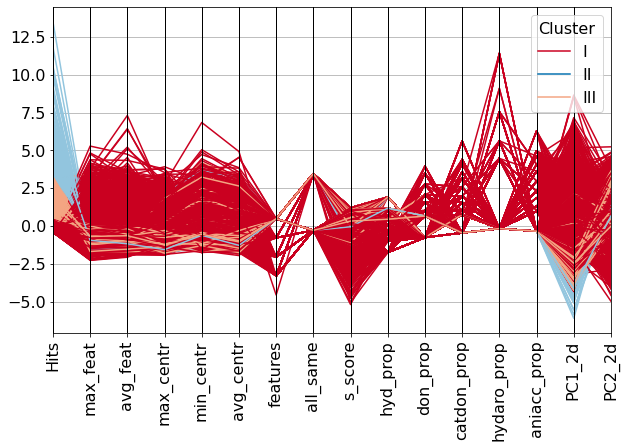

In [24]:
#parallel coordinates plot for training set
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})
#X_train_clstrs = X_train_clstrs.drop('PC1_2d', axis=1)
#X_train_clstrs = X_train_clstrs.drop('PC2_2d', axis=1)
plot = pd.plotting.parallel_coordinates(X_train_clstrs, 'clusters', color=['#ca0020','#f4a582','#92c5de'])
plot.tick_params(axis='x', rotation=90)
I_line = mlines.Line2D([], [], color='#ca0020', label='I')
II_line = mlines.Line2D([], [], color='#0571b0', label='II')
III_line = mlines.Line2D([], [], color='#f4a582', label='III')
plot.legend(title = "Cluster", handles = [I_line, II_line, III_line], loc = 'upper right')

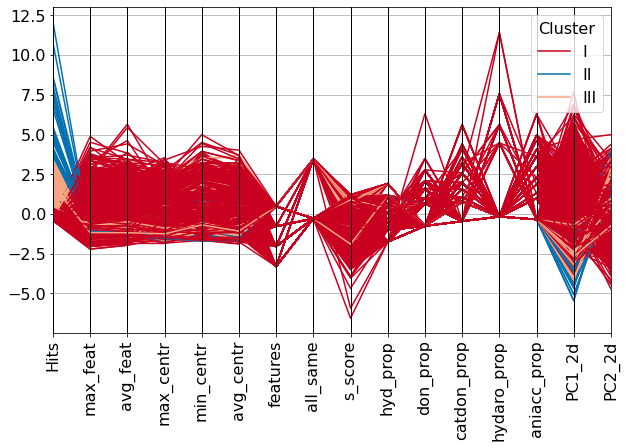

In [25]:
#parallel coordinates plot for test set
plt.figure(figsize=(10,6))
#X_test_clstrs = X_test_clstrs.drop('PC1_2d', axis=1)
#X_test_clstrs = X_test_clstrs.drop('PC2_2d', axis=1)
plot = pd.plotting.parallel_coordinates(X_test_clstrs, 'clusters', color=['#ca0020','#0571b0','#f4a582'])
plot.tick_params(axis='x', rotation=90)
I_line = mlines.Line2D([], [], color='#ca0020', label='I')
II_line = mlines.Line2D([], [], color='#0571b0', label='II')
III_line = mlines.Line2D([], [], color='#f4a582', label='III')
plot.legend(title = "Cluster", handles = [I_line, II_line, III_line], loc = 'upper right')

In [26]:
def scale_features_single(X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    applies standard scaler (z-scores) to training data and predicts z-scores for the test set
    """
    scaler = StandardScaler()
    to_scale = [col for col in X.columns.values]
    scaler.fit(X[to_scale])
    X[to_scale] = scaler.transform(X[to_scale])
    
    return X
      
def classify_ext_data(input_csv, subset = "none"):      
    ext_df = pd.read_csv(input_csv)
    ext_df.fillna(-99999)
    receptors = ext_df.Receptor
    hits_actual = ext_df.Hits
    score_types = ext_df['Score Type']
    subsets = ext_df.subset
    match_features = ext_df.match_features
    init_ext_df = ext_df
    
    #check if a 'quality' column exists. one will not exist if classifying data with unknown enrichments.
    if 'quality' not in ext_df:
        ext_df = ext_df[['s_score','Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop']]
        x = ext_df
    else:
        ext_df = ext_df[['s_score','Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop', 'quality']]   
        x = ext_df.drop('quality', axis=1)
        y = ext_df.quality
    
    predictors = list(ext_df.columns)
    predictors = predictors[:-1]
    print('Predictors:', predictors,'\n')
    
    if 'quality' in init_ext_df:
        print("score based Q ph4s:", y.sum(),'\n')
    
    #cluster training data
    clustering = KMeans(n_clusters=3, random_state=rng)
    clustering.fit(x_train)
    # apply the labels to the training set
    train_labels = clustering.labels_
    X_train_clstrs = x_train.copy()
    X_train_clstrs['clusters'] = train_labels
    
    # predict labels on the external set
    ext_labels = clustering.predict(x)
    X_clstrs = x.copy()
    X_clstrs['clusters'] = ext_labels
    
    X_scaled = scale_features_single(X_clstrs)
    ext_clusters = X_scaled.copy()
    if 'quality' in init_ext_df:
        ext_clusters['y'] = y
    
    #add receptors, hits_actual, score type, and subset columns back prior to 0/1/2/3 split
    ext_clusters['Receptor'] = receptors
    ext_clusters['hits_actual'] = hits_actual
    ext_clusters['Score Type'] = score_types
    ext_clusters['subset'] = subsets
    ext_clusters['match_features'] = match_features
    
    #write ext_clusters to csv
    #X_train_clstrs.to_csv('X_train_clstrs2.csv')
    
    # locate the "0" cluster
    ext_0 = ext_clusters.loc[ext_clusters.clusters <= uniqs[0]] # after scaling, 0 went negtive
    if 'quality' in init_ext_df:
        y_ext_0 = ext_0.y.values
    ext_0_receptors = ext_0.Receptor
    ext_0_hits_actual = ext_0.hits_actual
    ext_0_score_types = ext_0['Score Type']
    ext_0_subsets = ext_0.subset
    ext_0_match_features = ext_0.match_features
    
    # locate the "1" cluster
    ext_1 = ext_clusters.loc[(ext_clusters.clusters <= uniqs[1]) & (ext_clusters.clusters > uniqs[0])] # after scaling, 0 went negtive
    if 'quality' in init_ext_df:
        y_ext_1 = ext_1.y.values
    ext_1_receptors = ext_1.Receptor
    ext_1_hits_actual = ext_1.hits_actual
    ext_1_score_types = ext_1['Score Type']
    ext_1_subsets = ext_1.subset
    ext_1_match_features = ext_1.match_features
    
    # locate the "2" cluster
    ext_2 = ext_clusters.loc[(ext_clusters.clusters <= uniqs[2]) & (ext_clusters.clusters > uniqs[1])] # after scaling, 0 went negtive
    if 'quality' in init_ext_df:
        y_ext_2 = ext_2.y.values
    ext_2_receptors = ext_2.Receptor
    ext_2_hits_actual = ext_2.hits_actual
    ext_2_score_types = ext_2['Score Type']
    ext_2_subsets = ext_2.subset
    ext_2_match_features = ext_2.match_features

    # drop the targets from each external set (if classifying known external data)
    if 'quality' in init_ext_df:
        X_ext_0 = ext_0.drop(columns=['y', 'Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
        X_ext_1 = ext_1.drop(columns=['y', 'Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
        X_ext_2 = ext_2.drop(columns=['y', 'Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
    else:
        X_ext_0 = ext_0.drop(columns=['Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
        X_ext_1 = ext_1.drop(columns=['Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
        X_ext_2 = ext_2.drop(columns=['Receptor', 'hits_actual', 'Score Type', 'subset', 'match_features'])
    
    # drop receptor column from each external set
    
    #print(len(X_ext_0))
    #print(len(X_ext_1))
    #print(len(X_ext_2))
    #print(len(X_ext_3))
    
    #predict based on 0 cluster model
    print('0 cluster model\n')
    print('---------------\n')
    if len(X_ext_0) == 0:
        print('No cluster 0 data.\n')
    else:
        y_pred = (sgdc0.predict(X_ext_0))
        if 'quality' in init_ext_df:
            confmat = confusion_matrix(y_ext_0, y_pred, labels=[0,1])
            confmat = confusion_matrix(y_ext_0, y_pred, labels=[0,1]).ravel()
            FP = (confmat[1])
            TP = (confmat[3])
            PPV = (TP / (TP + FP))
            cm = pd.crosstab(y_ext_0, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
            print(cm,'\n')
            print('PPV:', format(PPV, '.2f'),'\n')
        
        X_ext_0['Receptor'] = ext_0_receptors
        X_ext_0['hits_actual'] = ext_0_hits_actual
        X_ext_0['Score Type'] = ext_0_score_types
        X_ext_0['subset'] = ext_0_subsets
        X_ext_0['match_features'] = ext_0_match_features
        if 'quality' in init_ext_df:
            X_ext_0['quality'] = y_ext_0
        
        X_ext_0['quality_pred'] = y_pred
        if 'quality' in init_ext_df:
            print('null')
            X_ext_0.to_csv('results/'+subset+'/k3_0cluster_results.csv')
        #if classifying unknown external data, print the ph4s classified as quality and write them to .csv
        if 'quality' not in init_ext_df:
            print(X_ext_0.loc[X_ext_0['quality_pred'] == 1], '\n')
            ph4_preds = X_ext_0.loc[X_ext_0['quality_pred'] == 1]
            #ph4_preds.to_csv('predictions/0cluster_ph4_preds.csv')

    print('1 cluster model\n')
    print('---------------\n')
    if len(X_ext_1) == 0:
        print('No cluster 1 data.\n')
    else:
        y_pred = (sgdc1.predict(X_ext_1))
        if 'quality' in init_ext_df:
            confmat = confusion_matrix(y_ext_1, y_pred, labels=[0,1])
            confmat = confusion_matrix(y_ext_1, y_pred, labels=[0,1]).ravel()
            FP = (confmat[1])
            TP = (confmat[3])
            PPV = (TP / (TP + FP))
            cm = pd.crosstab(y_ext_1, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
            print(cm,'\n')
            print('PPV:', format(PPV, '.2f'),'\n')
        
        X_ext_1['Receptor'] = ext_1_receptors
        X_ext_1['hits_actual'] = ext_1_hits_actual
        X_ext_1['Score Type'] = ext_1_score_types
        X_ext_1['subset'] = ext_1_subsets
        X_ext_1['match_features'] = ext_1_match_features
        if 'quality' in init_ext_df:
            X_ext_1['quality'] = y_ext_1
        
        X_ext_1['quality_pred'] = y_pred
        if 'quality' in init_ext_df:
            X_ext_1.to_csv('results/'+subset+'/k3_1cluster_results.csv')
            
        if 'quality' not in init_ext_df:
            print(X_ext_1.loc[X_ext_1['quality_pred'] == 1], '\n')
            ph4_preds = X_ext_1.loc[X_ext_1['quality_pred'] == 1]
            #ph4_preds.to_csv('predictions/1cluster_ph4_preds.csv')
        
    print('2 cluster model\n')
    print('---------------\n')
    if len(X_ext_2) == 0:
        print('No cluster 2 data.\n')
    else:
        y_pred = (sgdc2.predict(X_ext_2))
        if 'quality' in init_ext_df:
            confmat = confusion_matrix(y_ext_2, y_pred, labels=[0,1])
            confmat = confusion_matrix(y_ext_2, y_pred, labels=[0,1]).ravel()
            FP = (confmat[1])
            TP = (confmat[3])
            PPV = (TP / (TP + FP))
            cm = pd.crosstab(y_ext_2, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=False)
            print(cm,'\n')
            print('PPV:', format(PPV, '.2f'),'\n')
        
        X_ext_2['Receptor'] = ext_2_receptors
        X_ext_2['hits_actual'] = ext_2_hits_actual
        X_ext_2['Score Type'] = ext_2_score_types
        X_ext_2['subset'] = ext_2_subsets
        X_ext_2['match_features'] = ext_2_match_features
        if 'quality' in init_ext_df:
            X_ext_2['quality'] = y_ext_2
        
        X_ext_2['quality_pred'] = y_pred
        if 'quality' in init_ext_df:
            X_ext_2.to_csv('results/'+subset+'/k3_2cluster_results.csv')
        
        if 'quality' not in init_ext_df:
            print(X_ext_2.loc[X_ext_2['quality_pred'] == 1], '\n')
            ph4_preds = X_ext_2.loc[X_ext_2['quality_pred'] == 1]
            #ph4_preds.to_csv('predictions/2cluster_ph4_preds.csv')
        

In [27]:
classify_ext_data('..\..\data\score_based_alldata_binary.csv', 'all')

Predictors: ['s_score', 'Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop'] 

score based Q ph4s: 85 

0 cluster model

---------------

No cluster 0 data.

1 cluster model

---------------

Predicted   0   1
Actual           
0          85  90
1          29  56 

PPV: 0.38 

2 cluster model

---------------

No cluster 2 data.



In [28]:
classify_ext_data('..\..\data\hm_score_based_alldata_binary.csv', 'hm_all')

Predictors: ['s_score', 'Hits', 'max_feat', 'avg_feat', 'max_centr', 'min_centr', 'avg_centr', 'features', 'all_same', 'hyd_prop', 'don_prop', 'catdon_prop', 'hydaro_prop', 'aniacc_prop'] 

score based Q ph4s: 58 

0 cluster model

---------------

No cluster 0 data.

1 cluster model

---------------

Predicted   0    1
Actual            
0          85  117
1          30   28 

PPV: 0.19 

2 cluster model

---------------

No cluster 2 data.

